<a href="https://colab.research.google.com/github/aliaa-anx/celebrity-recognition-model/blob/aliaa/vgg_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports and Configuration**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

# 1. Define source and destination
zip_path = "/content/drive/MyDrive/Colab Notebooks/VGGFace2.zip"
dest_path = "/content/"

# 2. Check if the file is actually there
if os.path.exists(zip_path):
    print("Found zip file! Extracting now...")

    # -q = quiet (no print logs)
    # -o = overwrite (don't ask permission to replace files)
    !unzip -o -q "{zip_path}" -d "{dest_path}"

    print(" Extraction Complete!")
else:
    print(f" Error: Could not find the file at: {zip_path}")
    print("   Make sure your Drive is mounted and the file name is correct.")

Found zip file! Extracting now...
 Extraction Complete!


In [3]:

import os
import numpy as np
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# The unzipped folder will be in the root content directory
DATASET_PATH = "/content/VGGFace2"

# Double check if it's nested (sometimes zips create a folder inside a folder)
if os.path.exists("/content/VGGFace2/VGGFace2"):
    DATASET_PATH = "/content/VGGFace2/VGGFace2"
    # ... (Your existing code) ...

print(f"Dataset path set to: {DATASET_PATH}")

# --- ADD THIS VERIFICATION ---
if os.path.exists(DATASET_PATH):
    # Count how many sub-folders (celebrities) are inside
    num_classes = len([d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))])

    if num_classes > 0:
        print(f"Success! Found {num_classes} celebrity classes.")
    else:
        print(" Warning: The folder exists, but it looks empty. Check your unzip command.")
else:
    print(f" Error: The folder '{DATASET_PATH}' does not exist.")
    print("   Check the 'Files' sidebar to see the actual folder name.")

print(f"Dataset path set to: {DATASET_PATH}")

Dataset path set to: /content/VGGFace2
Success! Found 469 celebrity classes.
Dataset path set to: /content/VGGFace2


In [4]:
IMG_SIZE = 224
BATCH_SIZE = 32

**Class Discovery**

In [5]:
# Scan directory for celebrity folders
all_celebs = [c for c in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, c))]

# Filter: Only keep celebs with at least 30 images
# This reduces the class count but drastically improves accuracy
celebs_filtered= [c for c in all_celebs if len(os.listdir(os.path.join(DATASET_PATH, c)))>=30]

# Filter 2 (CRITICAL FOR SPEED):
# Only keep the first 50 celebrities.
# This changes your training time from 20 hours -> 30 minutes.
celebs = celebs_filtered[:100]

# Create a dictionary mapping class names to integer IDs
label_map = {celebrity: id for id, celebrity in enumerate(celebs)}
NUM_CLASSES = len(celebs)

print(f"Found {len(all_celebs)} total folders.")
print(f"Selected {NUM_CLASSES} celebrities")

Found 469 total folders.
Selected 100 celebrities


**load image paths**

In [6]:
image_paths = []
labels = []

for celebrity in celebs:
    celebrity_path = os.path.join(DATASET_PATH, celebrity)
    for img_name in os.listdir(celebrity_path):
        image_paths.append(os.path.join(celebrity_path, img_name))
        labels.append(label_map[celebrity])

# Convert to numpy arrays for easier indexing
image_paths = np.array(image_paths)
labels = np.array(labels, dtype=np.int32)

print(f"Total images found: {len(image_paths)}")

Total images found: 36358


**shuffling and splittingData**

In [7]:
# Generate shuffled indices
indices = np.arange(len(image_paths))
np.random.seed(42)
np.random.shuffle(indices)

# Apply shuffle
image_paths = image_paths[indices]
labels = labels[indices]

# Define split boundaries
train_end = int(0.7 * len(image_paths))
val_end   = int(0.85 * len(image_paths))

# Create splits
train_paths = image_paths[:train_end]
val_paths   = image_paths[train_end:val_end]
test_paths  = image_paths[val_end:]

train_labels = labels[:train_end]
val_labels   = labels[train_end:val_end]
test_labels  = labels[val_end:]

print(f"Training set: {len(train_paths)} images")
print(f"Validation set: {len(val_paths)} images")
print(f"Test set: {len(test_paths)} images")

Training set: 25450 images
Validation set: 5454 images
Test set: 5454 images


**Data Augmentation Pipeline**

In [8]:
# Define augmentation sequence
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.5),
    A.GaussianBlur(blur_limit=3, p=0.2),
    A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.3),
])

# Numpy wrapper for Albumentations
def augment_np(image, label):
    image = (image * 255.0).numpy().astype("uint8")
    aug = train_transform(image=image)["image"]
    aug = aug.astype("float32")
    return aug, label

# TensorFlow wrapper
def tf_augment(image, label):
    image, label = tf.py_function(func=augment_np, inp=[image, label], Tout=(tf.float32, tf.int32))
    # Explicitly set shape because py_function loses shape info
    image.set_shape((IMG_SIZE, IMG_SIZE, 3))
    label.set_shape(())
    return image, label

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


**Preprocessing & Dataset Generator**

In [9]:
import tensorflow as tf
import albumentations as A
import numpy as np
from tensorflow.keras.applications.vgg19 import preprocess_input

# Configuration
IMG_SIZE = 224
BATCH_SIZE = 32

# --- 1. DEFINE AUGMENTATION ---
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=20, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=0, p=0.5),
])

def augment_np(image, label):
    # --- THE FIX IS HERE ---
    # Convert TensorFlow Tensor -> NumPy Array -> uint8
    image = image.numpy().astype("uint8")

    aug = train_transform(image=image)["image"]

    # Convert back to float32 (0-255) for VGG
    aug = aug.astype("float32")
    return aug, label

def tf_augment(image, label):
    # Wrap the numpy function
    image, label = tf.py_function(func=augment_np, inp=[image, label], Tout=(tf.float32, tf.int32))

    # Fix shape info lost by py_function
    image.set_shape((IMG_SIZE, IMG_SIZE, 3))
    label.set_shape(())

    # Apply VGG Preprocessing (Mean Subtraction) AFTER augmentation
    image = preprocess_input(image)
    return image, label

# --- 2. BASE LOADERS ---
def load_base_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # Cast to float (0-255)
    image = tf.cast(image, tf.float32)
    return image, label

def process_validation(image, label):
    # Validation Data = No Augment -> Just VGG Processed
    image = preprocess_input(image)
    return image, label

# --- 3. DATASET CREATOR ---
def create_dataset(paths, labels, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    if augment:
        ds = ds.shuffle(buffer_size=5000)

    # Load raw images (0-255)
    ds = ds.map(load_base_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Branch: Augment vs Standard
    if augment:
        ds = ds.map(tf_augment, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.map(process_validation, num_parallel_calls=tf.data.AUTOTUNE)

    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

# --- 4. APPLY & VERIFY ---
train_dataset = create_dataset(train_paths, train_labels, augment=True)
val_dataset   = create_dataset(val_paths,   val_labels,   augment=False)

# Diagnostic Check
print("Checking data pipeline")
try:
    img, _ = next(iter(train_dataset))
    print(f"Stats check:")
    print(f"Min: {tf.reduce_min(img):.2f} (Should be neg)")
    print(f"Max: {tf.reduce_max(img):.2f} (Should be > 100)")
    print(" Pipeline Fixed!")
except Exception as e:
    print(f" Still Error: {e}")

Checking data pipeline
Stats check:
Min: -123.68 (Should be neg)
Max: 151.06 (Should be > 100)
 Pipeline Fixed!


In [ ]:
IMG_SIZE=224

**Initialize Datasets**

In [10]:
print("Creating datasets...")
train_dataset = create_dataset(train_paths, train_labels, augment=True)
val_dataset   = create_dataset(val_paths,   val_labels,   augment=False)
test_dataset  = create_dataset(test_paths,  test_labels,  augment=False)

print("Data pipeline ready for VGG-19!")

Creating datasets...
Data pipeline ready for VGG-19!


In [11]:
# 2. Sanity Check: Inspect one batch
print(" Checking data pipeline...")
images, labels = next(iter(train_dataset))

print(f"Image Batch Shape: {images.shape}") # Should be (32, 224, 224, 3)
print(f"Label Batch Shape: {labels.shape}") # Should be (32,)

# Check Values (Crucial for VGG)
min_val = tf.reduce_min(images).numpy()
max_val = tf.reduce_max(images).numpy()
print(f"Min Value: {min_val:.2f} (Should be negative, e.g., -120)")
print(f"Max Value: {max_val:.2f} (Should be positive, e.g., +150)")

if max_val <= 1.0:
    print(" WARNING: Images look normalized (0-1). VGG needs 0-255!")
else:
    print("DATA LOOKS GOOD for VGG-19.")

 Checking data pipeline...
Image Batch Shape: (32, 224, 224, 3)
Label Batch Shape: (32,)
Min Value: -123.68 (Should be negative, e.g., -120)
Max Value: 151.06 (Should be positive, e.g., +150)
DATA LOOKS GOOD for VGG-19.


**model imports and configuration**

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
#configuration for VF-19
IMG_SHAPE =(224, 224, 3)
#IMG_SIZE = IMG_SHAPE[0] # Extract image size from IMG_SHAPE
#BATCH_SIZE = 32 # Define a batch size

print(f"Model will classify {NUM_CLASSES} classes and image shape is {IMG_SHAPE}")

Model will classify 100 classes and image shape is (224, 224, 3)


***define vgg architecture***

In [13]:
def build_vgg19_model(input_shape, num_classes):
    model= models.Sequential(name="VGG-19")
    # Block 1  contains 2 convultional layers and 1 max pooling layer
    # activation relu>> to add complexity and non-linearity to the model
    #padding same>> to maintain the spatial dimensions of the input (will be halved after max pooling)

    # first and 2nd blocks have 64 filters each and rest of the blocks as we go
    # deeper will have 128,256,512,512 filters respectively  to notioce more complex features as we go deeper


    model.add(layers.Conv2D(64,(3,3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.Conv2D(64,(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

    # Block 2 contains 2 convultional layers and 1 max pooling layer
    model.add(layers.Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(128,(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

    # Block 3 contains 4 convultional layers and 1 max pooling layer
    model.add(layers.Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(256,(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

    # Block 4 contains 4 convultional layers and 1 max pooling layer
    model.add(layers.Conv2D(512,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512,(3,3), activation='relu',   padding='same'))
    model.add(layers.Conv2D(512,(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))

    # Block 5 contains 4 convultional layers and 1 max pooling layer
    model.add(layers.Conv2D(512,(3,3), activation='relu',   padding='same'))
    model.add(layers.Conv2D(512,(3,3), activation='relu', padding='same'))
    model.add(layers.Conv2D(512,(3,3), activation='relu',   padding='same'))
    model.add(layers.Conv2D(512,(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPooling2D((2,2), strides=(2,2)))


    # Flattening the layers to feed into fully connected layers(Dense layers considered the brain of the model)
    #model.add(layers.Flatten())

    #we have 3 dense layers in VGG-19
    #OPTION1 (HIGH RAM)
    # dense layer-1 with 4096 neurons and relu activation function
    #model.add(layers.Dense(4096, activation='relu'))
    #model.add(layers.Dropout(0.5)) #dropout to prevent overfitting


    # dense layer-2 with 4096 neurons and relu activation function
    #model.add(layers.Dense(4096, activation='relu'))
    #model.add(layers.Dropout(0.5))

    # output layer with number of neurons equal to number of classes and softmax activation function
    #model.add(layers.Dense(num_classes, activation='softmax')) #softmax for multiclass classification


    # OPTION B: The Fix (Light RAM) - Use this if Colab crashes!
    model.add(layers.GlobalAveragePooling2D()) # Turns 7x7x512 into just 512 numbers
    model.add(layers.Dense(512, activation='relu')) # Much smaller, easier to train
    model.add(layers.Dropout(0.5))


    # output layer with number of neurons equal to number of classes and softmax activation function
    model.add(layers.Dense(num_classes, activation='softmax')) #softmax for multiclass classification
    return model

print("VGG-19 architecture defined. ")

VGG-19 architecture defined. 


***instintiate the model and summarize it***

In [14]:
#call the function to build the model
vgg19_model= build_vgg19_model(input_shape=IMG_SHAPE, num_classes=NUM_CLASSES)

vgg19_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "VGG-19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 20,338,340 (77.58 MB)

 Trainable params: 20,338,340 (77.58 MB)

 Non-trainable params: 0 (0.00 B)

***compile the model***

In [15]:
#define the optimizer used adam with a learning rate of 0.0001(low)for stability
optimizer= optimizers.Adam(learning_rate=0.0001)

#compile the model with "sparse"categorical crossentropy loss(beacuse categorical cross entropy alone expects one-hot encoded labels)
vgg19_model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("Model compiled successfully with custom optimizer.")

Model compiled successfully with custom optimizer.


***define callbacks***

In [19]:
# define callbacks to manage training process
callbacks = [
    tf.keras.callbacks.ModelCheckpoint( "vgg19_best_model.keras",
        save_best_only=True,
        monitor="val_accuracy",
        mode="max",
        verbose=1
    ),
    # to stop training when the model stops improving to prevent overfitting
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=20,
        restore_best_weights=True,
        verbose=1
    )
]

In [20]:
# Grab a single batch
images, labels = next(iter(train_dataset))

print("--- LABEL REPORT ---")
print(f"Label Shape: {labels.shape}")
print(f"Sample Label: {labels[0]}")
print("--------------------")

--- LABEL REPORT ---
Label Shape: (32,)
Sample Label: 52
--------------------


***training the model***

In [18]:
print("Starting model training...")
# Train the model
history = vgg19_model.fit(
    train_dataset,
    epochs=25,
    validation_data=val_dataset,
    callbacks=callbacks
)

Starting model training...
Epoch 1/25
796/796 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.0128 - loss: 4.5997
Epoch 1: val_accuracy improved from -inf to 0.01412, saving model to vgg19_best_model.keras
796/796 ━━━━━━━━━━━━━━━━━━━━ 654s 767ms/step - accuracy: 0.0128 - loss: 4.5997 - val_accuracy: 0.0141 - val_loss: 4.5775
Epoch 2/25
796/796 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.0129 - loss: 4.5799
Epoch 2: val_accuracy improved from 0.01412 to 0.01558, saving model to vgg19_best_model.keras
796/796 ━━━━━━━━━━━━━━━━━━━━ 566s 711ms/step - accuracy: 0.0129 - loss: 4.5799 - val_accuracy: 0.0156 - val_loss: 4.5732
Epoch 3/25
796/796 ━━━━━━━━━━━━━━━━━━━━ 0s 666ms/step - accuracy: 0.0142 - loss: 4.5750
Epoch 3: val_accuracy did not improve from 0.01558
796/796 ━━━━━━━━━━━━━━━━━━━━ 562s 706ms/step - accuracy: 0.0142 - loss: 4.5750 - val_accuracy: 0.0156 - val_loss: 4.5720
Epoch 4/25
796/796 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.0143 - loss: 4.5753
Epoch 4: val_accurac

**Evaluation and Visualization**

In [21]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize

# 1. Generate Predictions
print("Generating predictions on Test Set...")
y_pred_probs = vgg19_model.predict(test_dataset)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# 2. Get True Labels
# Extract true labels from the dataset generator
y_true = np.concatenate([y for x, y in test_dataset], axis=0)

print("Predictions complete.")

Generating predictions on Test Set...
171/171 ━━━━━━━━━━━━━━━━━━━━ 33s 189ms/step
Predictions complete.


**Classification Report**

In [22]:
# 3. Classification Report
print("\n--- Classification Report ---")

# Filter target names to only those present in test set
present_classes = np.unique(y_true)
target_names = [name for name, id in label_map.items() if id in present_classes]

print(classification_report(y_true, y_pred_classes, labels=present_classes, target_names=target_names))


--- Classification Report ---
                              precision    recall  f1-score   support

               Ante Gotovina       0.00      0.00      0.00        65
               Alexis Valdés       0.00      0.00      0.00        19
           Agus Martowardojo       0.00      0.00      0.00        59
                Aamna Sharif       0.00      0.00      0.00        60
                Brandon Ríos       0.00      0.00      0.00        33
         Aníbal Cavaco Silva       0.00      0.00      0.00        72
          Alessandra Negrini       0.00      0.00      0.00        59
                Bárbara Mori       0.00      0.00      0.00        78
Alecsandro Barbosa Felisbino       0.00      0.00      0.00        39
                 Adam Duritz       0.00      0.00      0.00        55
                 Al Sharpton       0.00      0.00      0.00        77
              Akbar Tandjung       0.00      0.00      0.00        43
              Amber Valletta       0.00      0.00      0.0

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Confusion Matrix**

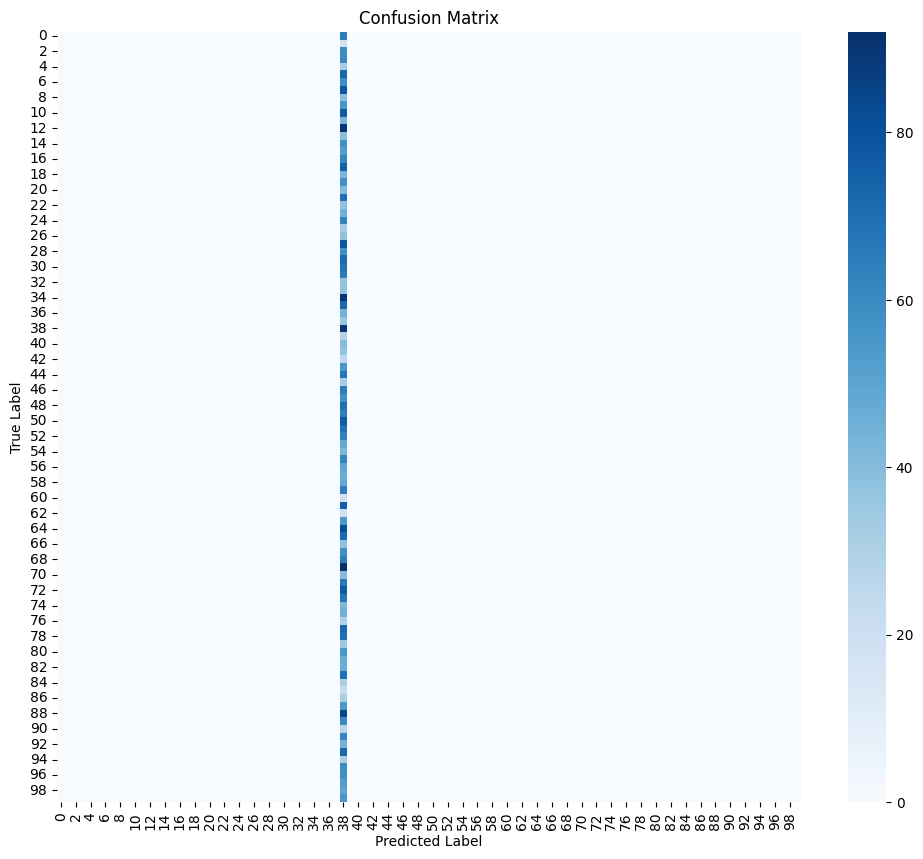

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# 4. Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

**raining History (Accuracy & Loss)**

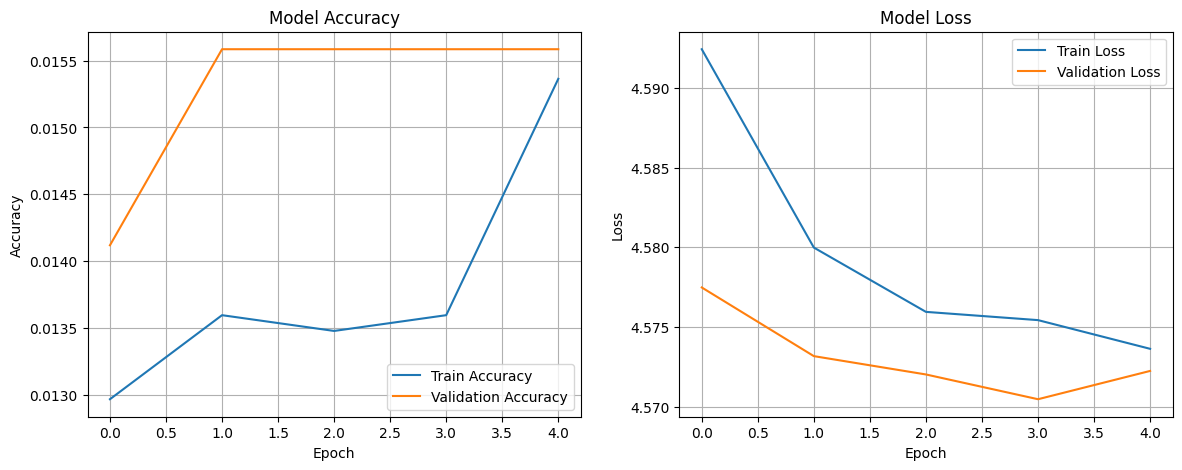

In [24]:
# 5. Training History Plots
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

Created folder: /content/drive/MyDrive/Colab Notebooks/VGG19_LFW_Results
 Model saved to Google Drive!
 Confusion Matrix saved!
✅ ROC Curve saved!


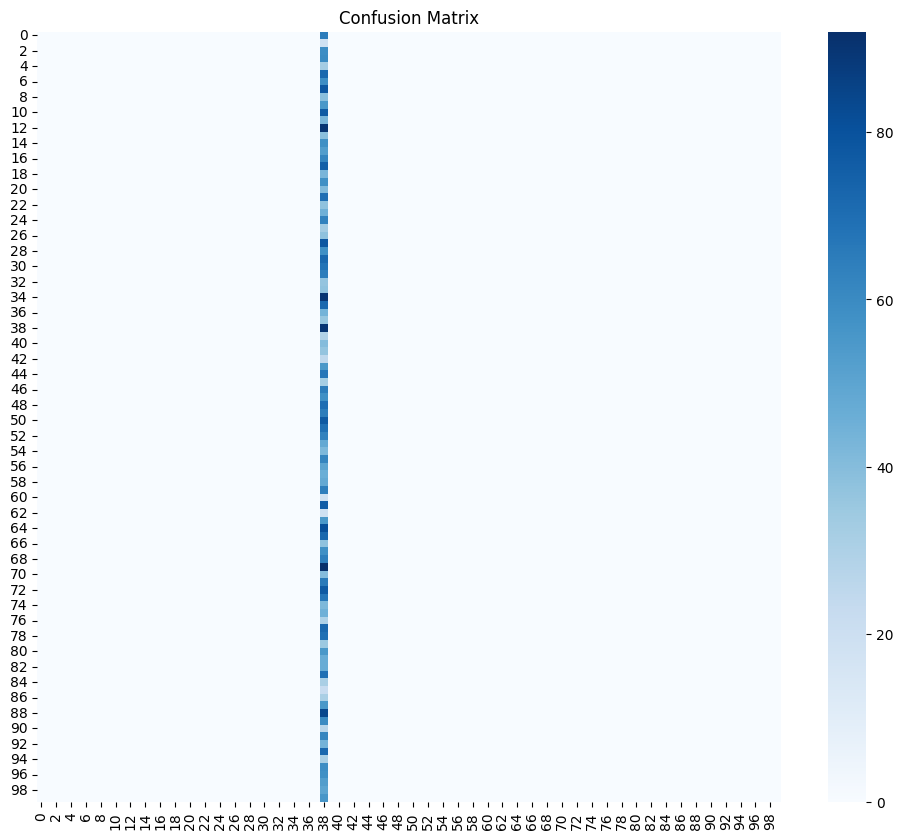

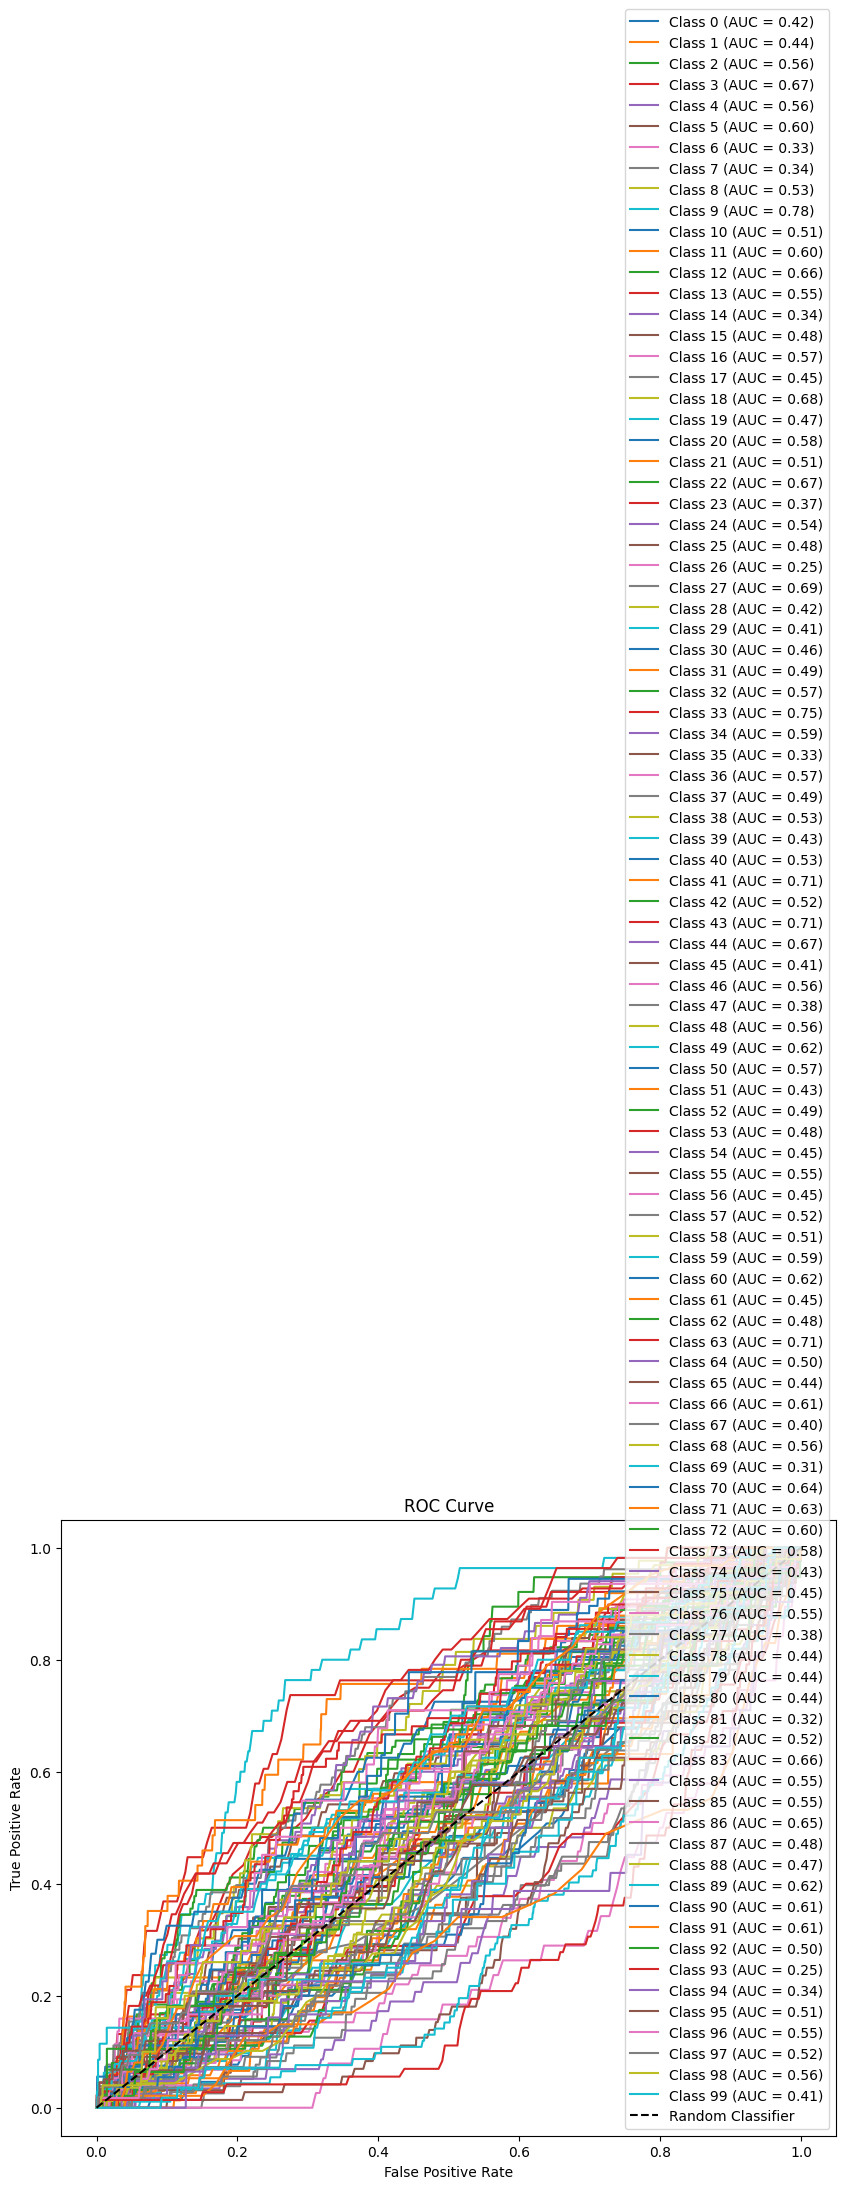

In [25]:
import shutil
import os

# 1. Create a folder in your Drive to store results
drive_save_path = "/content/drive/MyDrive/Colab Notebooks/VGG19_LFW_Results"
if not os.path.exists(drive_save_path):
    os.makedirs(drive_save_path)
    print(f"Created folder: {drive_save_path}")

# 2. Save your trained model
# (This copies the file we saved during training to your Drive)
try:
    shutil.copy("vgg19_best_model.keras", f"{drive_save_path}/vgg19_best_model.keras")
    print(" Model saved to Google Drive!")
except FileNotFoundError:
    print(" Could not find 'vgg19_best_model.keras'. Did the training finish?")

# 3. Save your Evaluation Charts
# If you ran the evaluation cell, save the plot figures
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig(f"{drive_save_path}/confusion_matrix.png")
print(" Confusion Matrix saved!")

# Prepare data for ROC curve
y_test_bin = label_binarize(y_true, classes=range(NUM_CLASSES))
fpr = dict()
tpr = dict()

plt.figure(figsize=(10, 8))
# (Re-plotting ROC to save it)
for i in range(NUM_CLASSES):
    # Ensure there are positive samples for the class in the test set
    # and that the class is among the top 5 to plot (optional, can plot all)
    if np.sum(y_test_bin[:, i]) > 0:
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {auc(fpr[i], tpr[i]):.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.savefig(f"{drive_save_path}/roc_curve.png")
print("✅ ROC Curve saved!")